In [2]:
import pandas as pd

# 读取数据
data = pd.read_csv('abalone.data.csv')

# 查看数据的基本信息
print('数据基本信息：')
data.info()

# 查看数据集行数和列数
rows, columns = data.shape

if rows > 0:
    # 查看数据集前几行
    print('数据前几行信息：')
    print(data.head().to_csv(sep='\t', na_rep='nan'))
else:
    print('数据为空。')

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
数据前几行信息：
	gender	Length	Diameter	Height	Whole weight	Shucked weight	Viscera weight	Shell weight	Rings
0	M	0.455	0.365	0.095	0.514	0.2245	0.101	0.15	15
1	M	0.35	0.265	0.09	0.2255	0.0995	0.0485	0.07	7
2	F	0.53	0.42	0.135	0.677	0.2565	0.1415	0.21	9
3	M	0.44	0.365	0.125	0.516	0.2155	0.114	0.155	10
4	I	0.33	0.255	0.08	0.205	0.0895

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# 数据预处理函数
def preprocess_data(data):
    # 分离分类特征和数值特征
    categorical_features = ['gender']
    numerical_features = [col for col in data.columns if col != 'gender' and col != 'Rings']
    
    # 方法1：使用pandas的get_dummies，保留所有类别
    # encoded_df = pd.get_dummies(data[categorical_features], prefix_sep='_')
    
    # 方法2：使用OneHotEncoder，指定要保留的类别
    encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
    encoded_features = encoder.fit_transform(data[categorical_features])
    
    # 创建独热编码的DataFrame，只保留F和M列
    categories = encoder.categories_[0]
    columns_to_keep = ['gender_F', 'gender_M']
    
    # 创建所有列
    all_columns = [f'gender_{cat}' for cat in categories]
    encoded_df = pd.DataFrame(encoded_features, columns=all_columns)
    
    # 只保留F和M列（如果存在）
    encoded_df = encoded_df[[col for col in columns_to_keep if col in encoded_df.columns]]
    
    # 将编码后的特征与原始数据合并
    data_encoded = pd.concat([data.drop(categorical_features, axis=1).reset_index(drop=True), 
                              encoded_df.reset_index(drop=True)], axis=1)
    
    # 标准化数值特征
    scaler = MinMaxScaler()
    data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])
    
    return data_encoded, numerical_features

# 读取数据
data = pd.read_csv('abalone.data.csv')
print(f"原始数据形状: {data.shape}")

# 数据预处理
data_encoded, numerical_features = preprocess_data(data)

# 打印处理后的数据前几行
print("\n处理后的数据前几行:")
print(data_encoded.head())

# 分割数据
X = data_encoded.drop('Rings', axis=1)
y = data_encoded['Rings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 打印训练集和测试集的形状
print(f"训练集形状: {X_train.shape}")
print(f"测试集形状: {X_test.shape}")


原始数据形状: (4177, 9)

处理后的数据前几行:
     Length  Diameter    Height  Whole weight  Shucked weight  Viscera weight  \
0  0.513514  0.521008  0.084071      0.181335        0.150303        0.132324   
1  0.371622  0.352941  0.079646      0.079157        0.066241        0.063199   
2  0.614865  0.613445  0.119469      0.239065        0.171822        0.185648   
3  0.493243  0.521008  0.110619      0.182044        0.144250        0.149440   
4  0.344595  0.336134  0.070796      0.071897        0.059516        0.051350   

   Shell weight  Rings  gender_F  gender_M  
0      0.147982     15       0.0       1.0  
1      0.068261      7       0.0       1.0  
2      0.207773      9       1.0       0.0  
3      0.152965     10       0.0       1.0  
4      0.053313      7       0.0       0.0  
训练集形状: (2923, 9)
测试集形状: (1254, 9)


我们使用DBSCAN聚类来检测鲍鱼数据集中的异常值，评估数据质量。


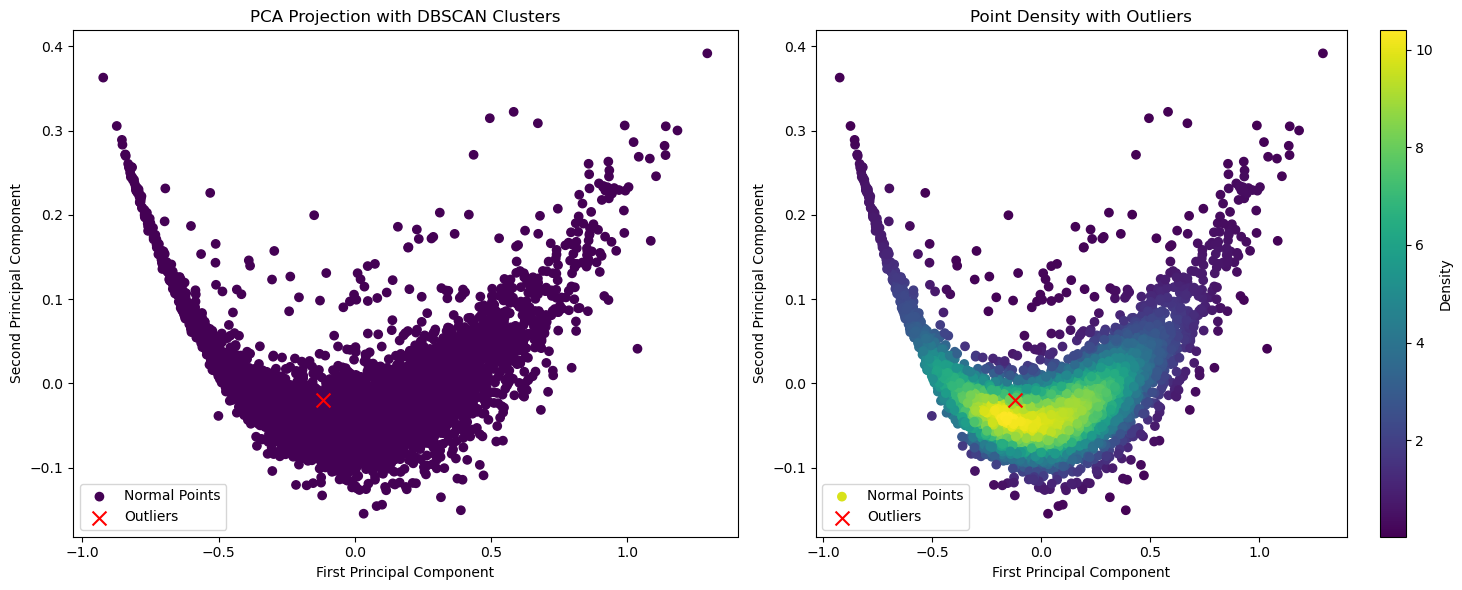


异常值详细信息:
原始特征值:
Length            0.513514
Diameter          0.504202
Height            1.000000
Whole weight      0.209669
Shucked weight    0.222596
Viscera weight    0.152074
Shell weight      0.131540
Name: 2051, dtype: float64

PCA坐标:
PC1: -0.1191
PC2: -0.0195

聚类数量: 1
异常值数量: 1
异常值比例: 0.02%
异常值数量: 1
聚类 0 的样本数量: 4176


In [2]:
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde

# DBSCAN异常值检测函数
def detect_outliers_dbscan(data, features, eps=0.3, min_samples=3):
    """
    使用DBSCAN聚类算法检测异常值
    
    参数:
    data: DataFrame, 包含所有特征的数据
    features: list, 用于检测异常值的特征列表
    eps: float, DBSCAN的eps参数
    min_samples: int, DBSCAN的min_samples参数
    
    返回:
    outliers: 布尔数组，True表示异常值
    clusters: 整数数组，表示每个点所属的聚类
    """
    # 使用DBSCAN进行聚类
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data[features])
    
    # 标记异常值（DBSCAN将噪声点标记为-1）
    outliers = clusters == -1
    
    return outliers, clusters

def visualize_results(data_encoded, numerical_features, outliers, clusters):
    # 使用PCA降维到2维进行可视化
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(data_encoded[numerical_features])
    
    # 创建图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 第一个子图：PCA散点图
    scatter1 = ax1.scatter(X_2d[~outliers, 0], X_2d[~outliers, 1], 
                          c=clusters[~outliers], cmap='viridis', 
                          label='Normal Points')
    scatter2 = ax1.scatter(X_2d[outliers, 0], X_2d[outliers, 1], 
                          c='red', marker='x', s=100, 
                          label='Outliers')
    ax1.set_xlabel('First Principal Component')
    ax1.set_ylabel('Second Principal Component')
    ax1.set_title('PCA Projection with DBSCAN Clusters')
    ax1.legend()
    
    # 第二个子图：密度图
    # 计算点密度
    if sum(~outliers) > 1:  # 确保有足够的非异常点来计算密度
        xy = np.vstack([X_2d[~outliers, 0], X_2d[~outliers, 1]])
        z = gaussian_kde(xy)(xy)
        
        scatter3 = ax2.scatter(X_2d[~outliers, 0], X_2d[~outliers, 1], 
                              c=z, cmap='viridis', 
                              label='Normal Points')
        scatter4 = ax2.scatter(X_2d[outliers, 0], X_2d[outliers, 1], 
                              c='red', marker='x', s=100, 
                              label='Outliers')
        ax2.set_xlabel('First Principal Component')
        ax2.set_ylabel('Second Principal Component')
        ax2.set_title('Point Density with Outliers')
        ax2.legend()
        
        plt.colorbar(scatter3, ax=ax2, label='Density')
    else:
        ax2.text(0.5, 0.5, "Not enough non-outlier points for density estimation", 
                ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 打印异常值的信息
    if sum(outliers) > 0:
        outlier_idx = np.where(outliers)[0][0]
        print("\n异常值详细信息:")
        print("原始特征值:")
        print(data_encoded.iloc[outlier_idx][numerical_features])
        print("\nPCA坐标:")
        print(f"PC1: {X_2d[outlier_idx, 0]:.4f}")
        print(f"PC2: {X_2d[outlier_idx, 1]:.4f}")

# 使用DBSCAN进行异常值检测
print(f"我们使用DBSCAN聚类来检测鲍鱼数据集中的异常值，评估数据质量。")
outliers, clusters = detect_outliers_dbscan(data_encoded, numerical_features, 
                                          eps=0.3, min_samples=3)

# 可视化结果
visualize_results(data_encoded, numerical_features, outliers, clusters)

# 打印聚类信息
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"\n聚类数量: {n_clusters}")
print(f"异常值数量: {sum(outliers)}")
print(f"异常值比例: {sum(outliers)/len(data_encoded)*100:.2f}%")

# 打印每个聚类的样本数量
for cluster in sorted(set(clusters)):
    if cluster == -1:
        print(f"异常值数量: {sum(clusters == cluster)}")
    else:
        print(f"聚类 {cluster} 的样本数量: {sum(clusters == cluster)}")


数据质量极好，异常值比例极低，数据点高度集中
建议保留原始数据，不需要异常值处理

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 创建线性回归模型
lr_model = LinearRegression()

# 训练模型
lr_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lr_model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("线性回归模型评估:")
print(f"均方误差 (MSE): {mse:.4f}")
print(f"均方根误差 (RMSE): {rmse:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"决定系数 (R²): {r2:.4f}")

# 查看各特征的系数
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
})
print("\n特征系数:")
print(coefficients.sort_values(by='Coefficient', ascending=False))


线性回归模型评估:
均方误差 (MSE): 4.7848
均方根误差 (RMSE): 2.1874
平均绝对误差 (MAE): 1.5832
决定系数 (R²): 0.5288

特征系数:
          Feature  Coefficient
3    Whole weight    28.148516
2          Height    11.446565
6    Shell weight     7.983249
1        Diameter     6.082596
0          Length     0.506736
8        gender_M     0.096717
7        gender_I    -0.726801
5  Viscera weight    -8.124979
4  Shucked weight   -31.998073


图1: 预测值与实际值的散点图
作用: 展示模型预测值与实际值的对应关系，理想情况下点应分布在45度线附近
分析要点: 观察点是否均匀分布在对角线周围，偏离对角线的点表示预测误差较大的样本
适用场景: 结果章节，用于直观展示模型整体预测精度


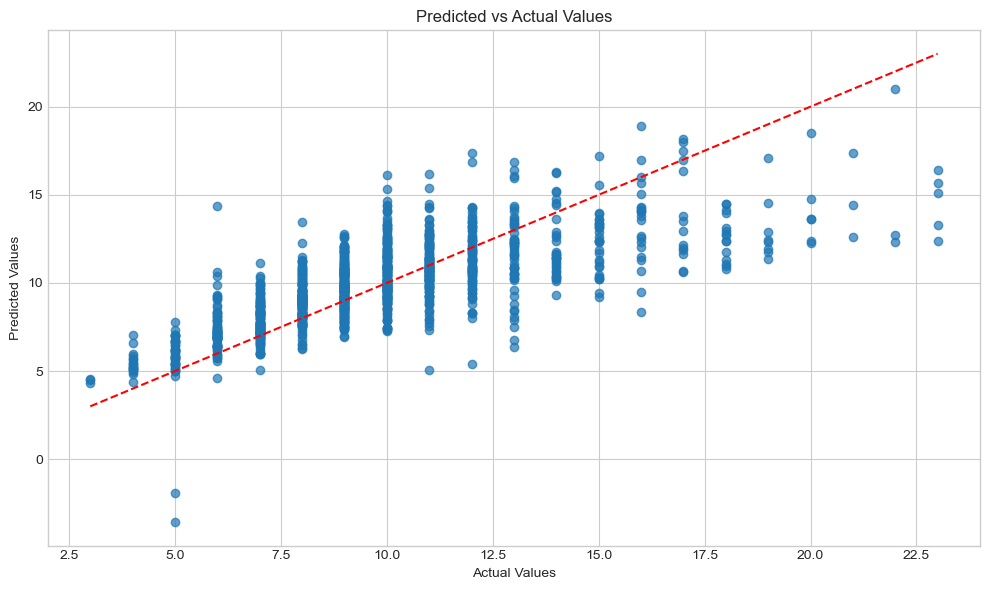


图2: 残差图
作用: 检验线性回归模型的假设条件，评估预测误差的分布模式
分析要点: 残差应随机分布在零线周围，无明显模式；存在模式表明模型可能遗漏了某些关系
适用场景: 方法验证部分，用于检验模型假设并识别潜在问题


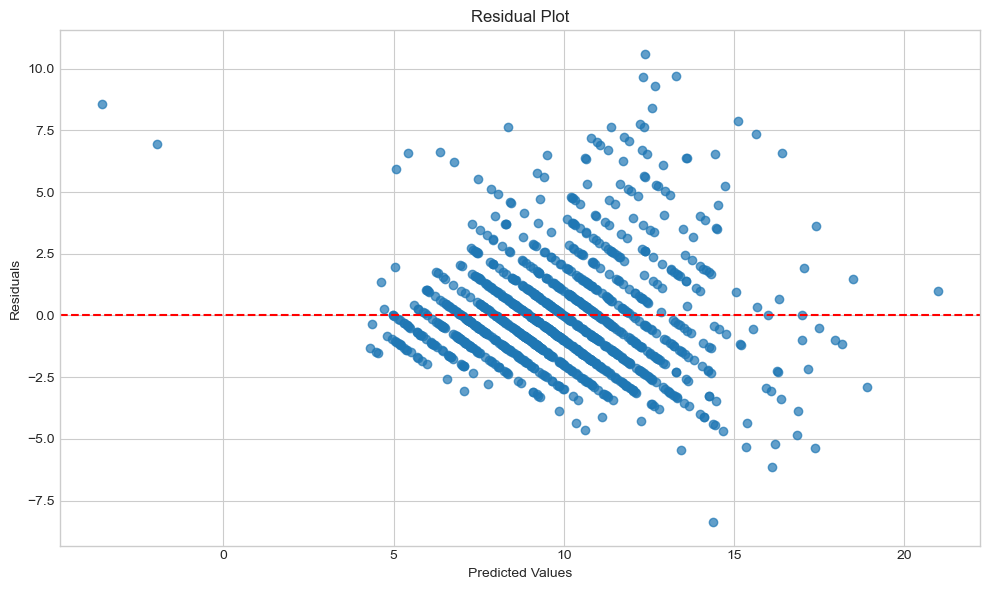


图3: 残差分布直方图
作用: 检验残差的正态性假设，评估模型误差的统计特性
分析要点: 理想情况下应呈现正态分布，偏斜或多峰分布可能表明模型存在系统性问题
适用场景: 方法验证部分，用于评估模型误差的统计特性


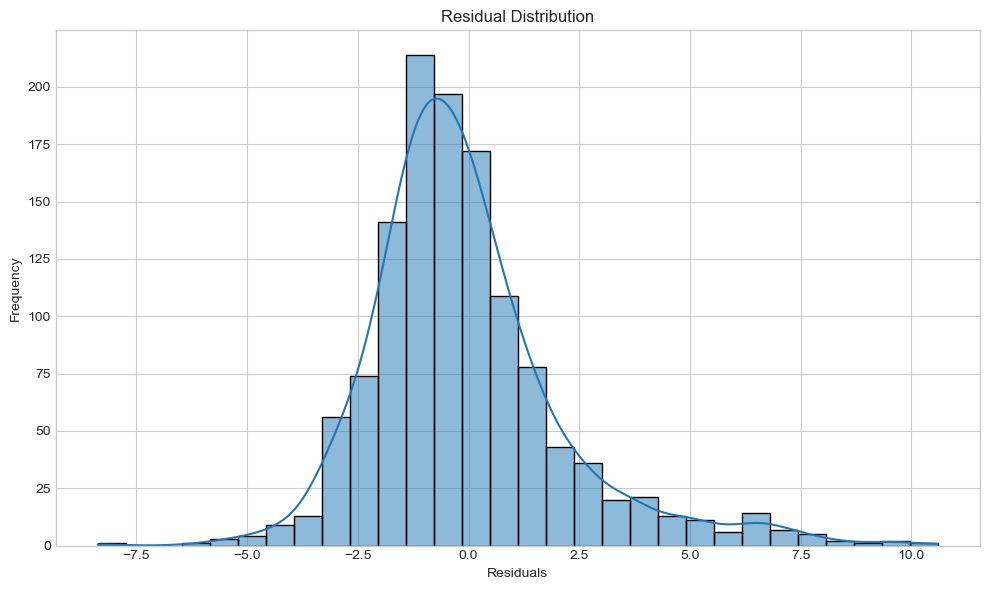


图4: 特征系数可视化
作用: 展示各特征对目标变量的影响方向和强度
分析要点: 系数大小表示影响强度，正负号表示影响方向，可用于特征重要性分析
适用场景: 结果章节或讨论章节，用于解释模型内部机制和变量关系


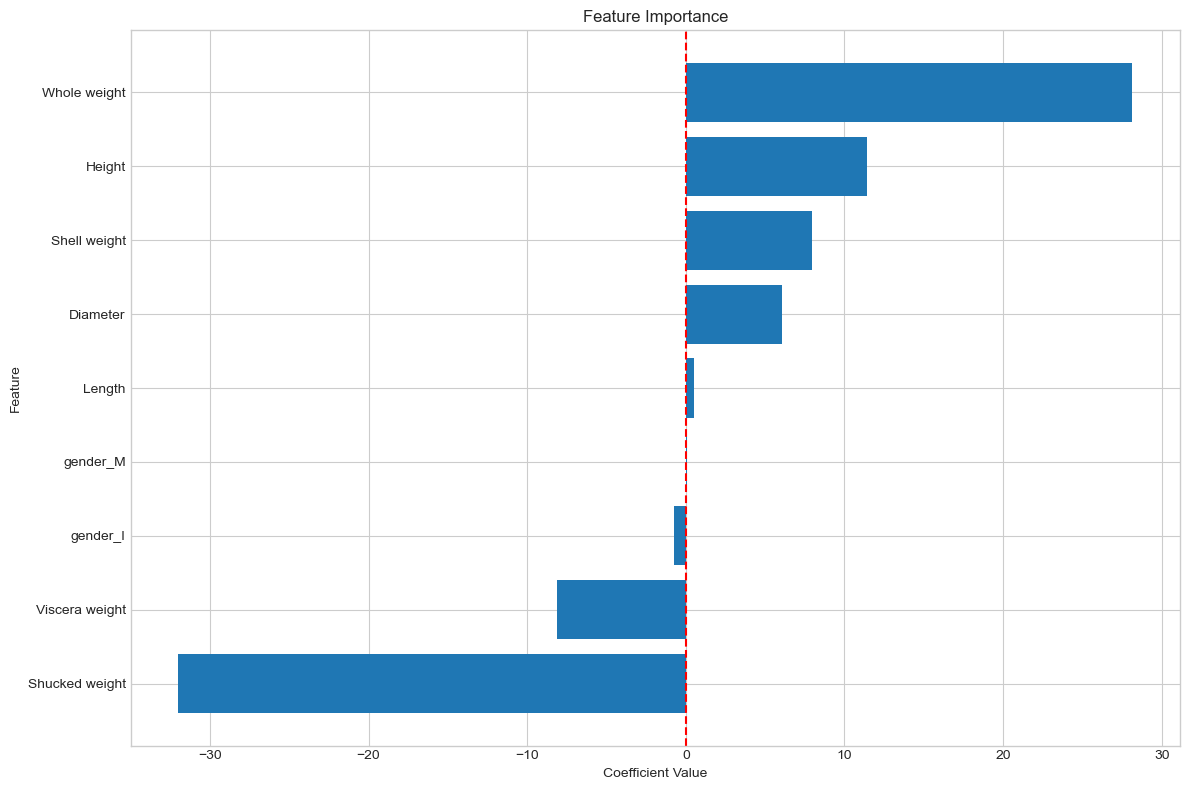


图5: 预测值与实际值的分布比较
作用: 比较预测值和实际值的整体分布特性
分析要点: 两条分布曲线应尽量重合，差异表明模型在某些值区间的预测偏差
适用场景: 结果章节，用于评估模型捕捉数据整体分布的能力


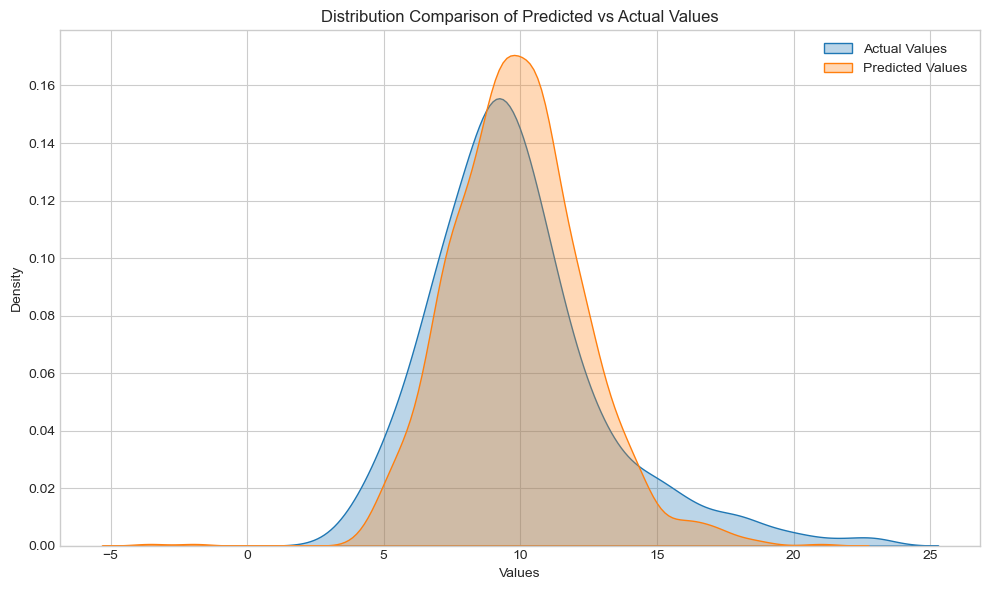

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图表风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# 图1说明
print("图1: 预测值与实际值的散点图")
print("作用: 展示模型预测值与实际值的对应关系，理想情况下点应分布在45度线附近")
print("分析要点: 观察点是否均匀分布在对角线周围，偏离对角线的点表示预测误差较大的样本")
print("适用场景: 结果章节，用于直观展示模型整体预测精度")

# 图1: 预测值与实际值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.tight_layout()
plt.show()

# 图2说明
print("\n图2: 残差图")
print("作用: 检验线性回归模型的假设条件，评估预测误差的分布模式")
print("分析要点: 残差应随机分布在零线周围，无明显模式；存在模式表明模型可能遗漏了某些关系")
print("适用场景: 方法验证部分，用于检验模型假设并识别潜在问题")

# 图2: 残差图
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# 图3说明
print("\n图3: 残差分布直方图")
print("作用: 检验残差的正态性假设，评估模型误差的统计特性")
print("分析要点: 理想情况下应呈现正态分布，偏斜或多峰分布可能表明模型存在系统性问题")
print("适用场景: 方法验证部分，用于评估模型误差的统计特性")

# 图3: 残差分布直方图
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

# 图4说明
print("\n图4: 特征系数可视化")
print("作用: 展示各特征对目标变量的影响方向和强度")
print("分析要点: 系数大小表示影响强度，正负号表示影响方向，可用于特征重要性分析")
print("适用场景: 结果章节或讨论章节，用于解释模型内部机制和变量关系")

# 图4: 特征系数可视化
plt.figure(figsize=(12, 8))
sorted_coef = coefficients.sort_values(by='Coefficient')
plt.barh(sorted_coef['Feature'], sorted_coef['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# 图5说明
print("\n图5: 预测值与实际值的分布比较")
print("作用: 比较预测值和实际值的整体分布特性")
print("分析要点: 两条分布曲线应尽量重合，差异表明模型在某些值区间的预测偏差")
print("适用场景: 结果章节，用于评估模型捕捉数据整体分布的能力")

# 图5: 预测值与实际值的分布比较
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual Values', fill=True, alpha=0.3)
sns.kdeplot(y_pred, label='Predicted Values', fill=True, alpha=0.3)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution Comparison of Predicted vs Actual Values')
plt.legend()
plt.tight_layout()
plt.show()


决策树模型性能 (默认参数):
均方误差 (MSE): 8.5853
均方根误差 (RMSE): 2.9301
平均绝对误差 (MAE): 2.0271
决定系数 (R²): 0.1545


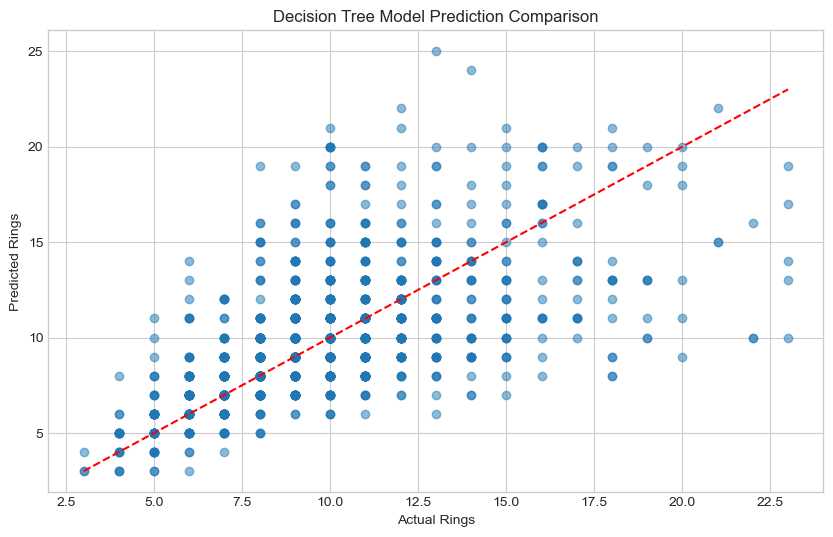


最佳参数:
max_depth: 5
min_samples_leaf: 8
min_samples_split: 2

优化后的决策树模型性能:
均方误差 (MSE): 5.4000
均方根误差 (RMSE): 2.3238
平均绝对误差 (MAE): 1.6300
决定系数 (R²): 0.4682


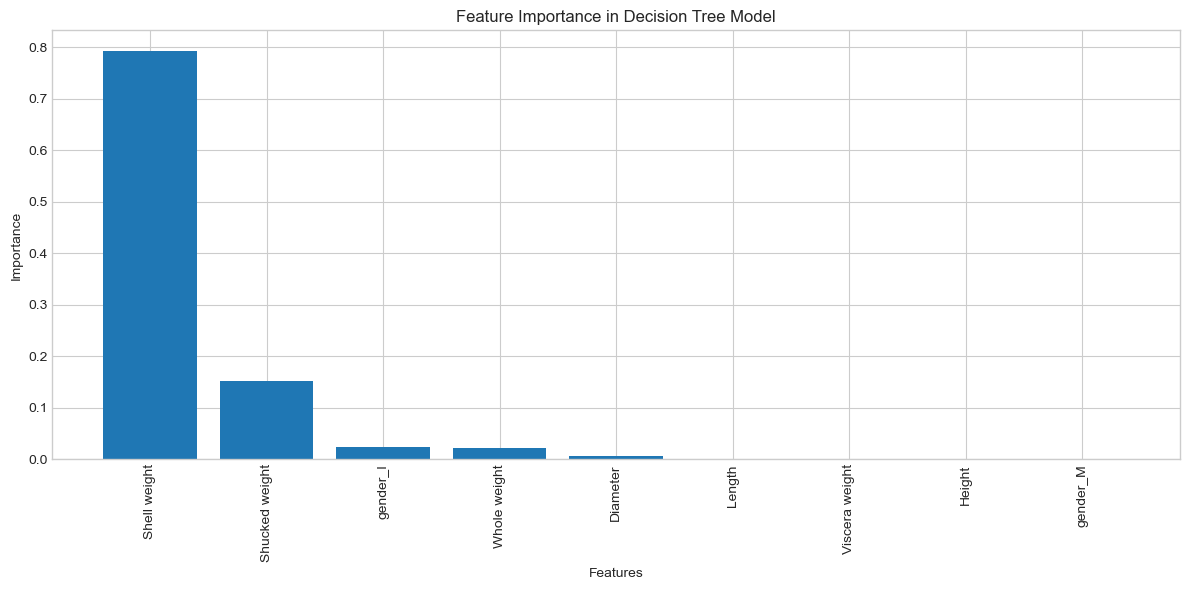

KeyboardInterrupt: 

In [ ]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import pandas as pd

# 1. 创建决策树回归模型（先使用默认参数）
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

# 2. 在测试集上进行预测
y_pred = dt_regressor.predict(X_test)

# 3. 评估模型性能
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("决策树模型性能 (默认参数):")
print(f"均方误差 (MSE): {mse:.4f}")
print(f"均方根误差 (RMSE): {rmse:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"决定系数 (R²): {r2:.4f}")

# 4. 可视化实际值与预测值的对比
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('Decision Tree Model Prediction Comparison')
plt.grid(True)
plt.show()

# 5. 超参数调优
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 6. 输出最佳参数
best_params = grid_search.best_params_
print("\n最佳参数:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# 7. 使用最佳参数重新训练模型
best_dt = grid_search.best_estimator_
best_dt.fit(X_train, y_train)
best_pred = best_dt.predict(X_test)

# 8. 评估优化后的模型性能
best_mse = mean_squared_error(y_test, best_pred)
best_rmse = np.sqrt(best_mse)
best_mae = mean_absolute_error(y_test, best_pred)
best_r2 = r2_score(y_test, best_pred)

print("\n优化后的决策树模型性能:")
print(f"均方误差 (MSE): {best_mse:.4f}")
print(f"均方根误差 (RMSE): {best_rmse:.4f}")
print(f"平均绝对误差 (MAE): {best_mae:.4f}")
print(f"决定系数 (R²): {best_r2:.4f}")

# 9. 特征重要性分析
feature_importance = best_dt.feature_importances_
feature_names = X_train.columns

# 创建特征重要性DataFrame并排序
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Decision Tree Model')
plt.tight_layout()
plt.show()

# 10. 可视化决策树（如果树不太大）
if best_params['max_depth'] is not None and best_params['max_depth'] <= 5:
    plt.figure(figsize=(20, 10))
    tree.plot_tree(best_dt, 
                   feature_names=feature_names,
                   filled=True, 
                   rounded=True, 
                   fontsize=10)
    plt.title('Decision Tree Visualization')
    plt.show()
else:
    print("\n决策树太大，无法可视化完整树结构。")
    
    # 可视化一个简化版的树（限制深度为3）
    simplified_dt = DecisionTreeRegressor(max_depth=3, random_state=42)
    simplified_dt.fit(X_train, y_train)
    
    plt.figure(figsize=(20, 10))
    tree.plot_tree(simplified_dt, 
                   feature_names=feature_names,
                   filled=True, 
                   rounded=True, 
                   fontsize=10)
    plt.title('Simplified Decision Tree (max_depth=3)')
    plt.show()

# 11. 学习曲线分析 - 观察训练集大小对性能的影响
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_dt, X_train, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='neg_mean_squared_error'
)

# 计算平均值和标准差
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 绘制学习曲线
plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1, color="r")
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curves for Decision Tree")
plt.legend(loc="best")
plt.show()




基础随机森林模型评估:
均方误差 (MSE): 4.7898
均方根误差 (RMSE): 2.1886
平均绝对误差 (MAE): 1.5416
决定系数 (R²): 0.5283

交叉验证 RMSE: 2.1967 ± 0.5004
Fitting 3 folds for each of 8 candidates, totalling 24 fits

最佳参数:
{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

优化后的随机森林模型评估:
均方误差 (MSE): 4.7478
均方根误差 (RMSE): 2.1789
平均绝对误差 (MAE): 1.5394
决定系数 (R²): 0.5324

特征重要性:
          Feature  Importance
6    Shell weight    0.513970
4  Shucked weight    0.166214
3    Whole weight    0.079662
5  Viscera weight    0.063774
1        Diameter    0.053417
2          Height    0.050377
0          Length    0.044510
7        gender_I    0.021622
8        gender_M    0.006453


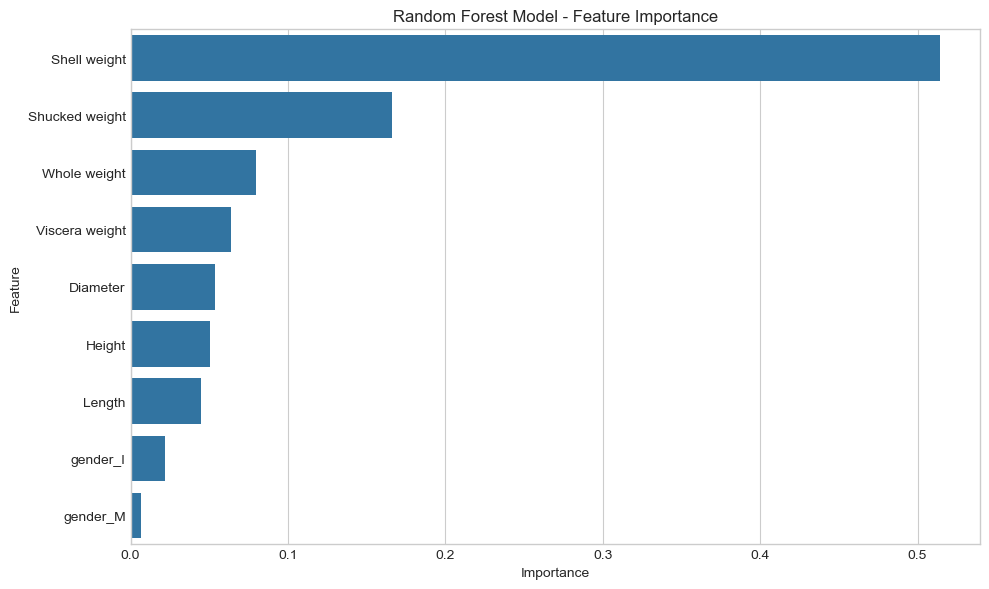

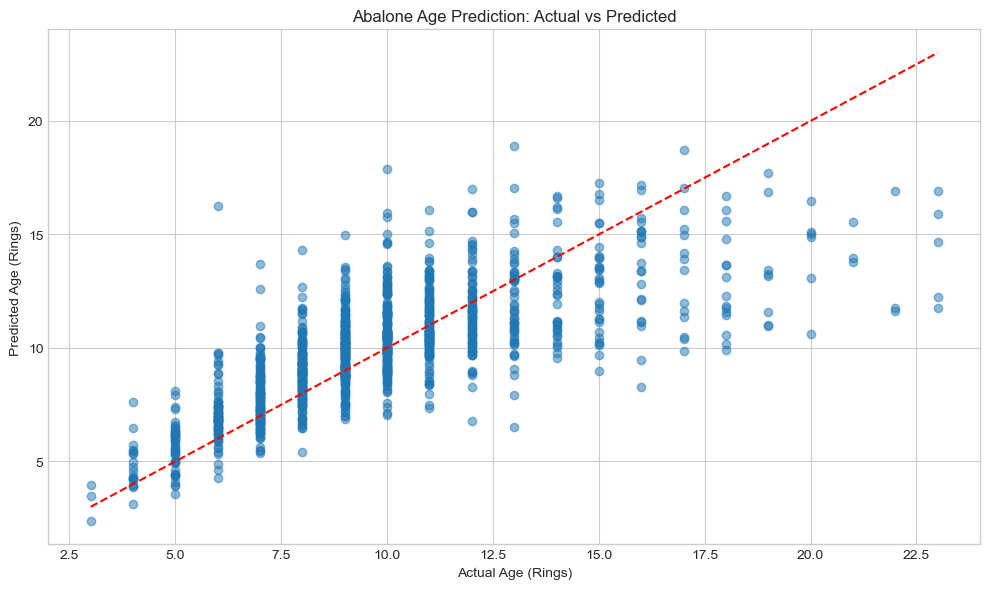

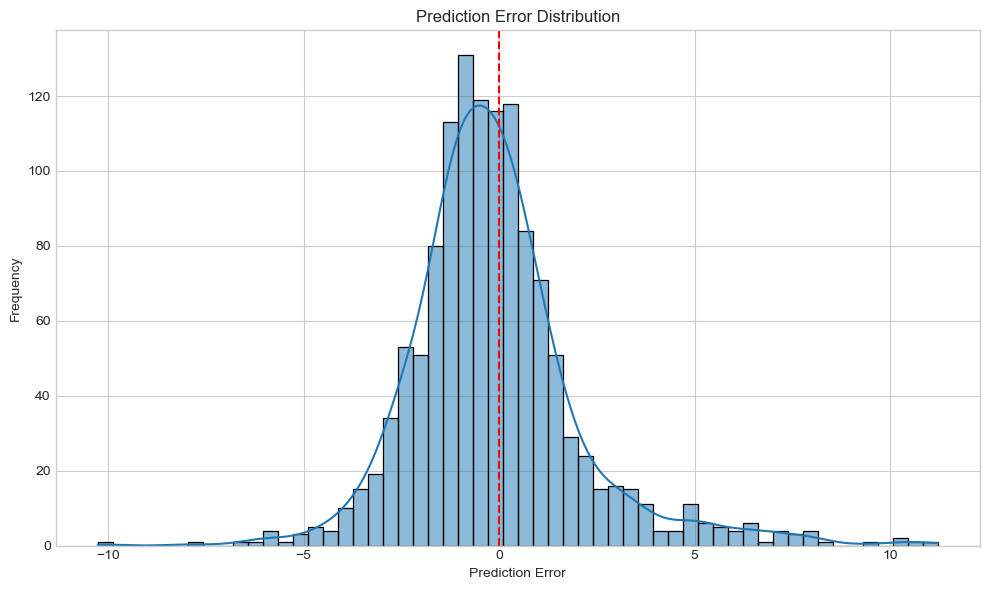


模型已保存为 'abalone_rf_model.pkl'

模型加载和使用示例:
样本预测结果:
[12.33457756  9.31977217 15.13918416 11.14039035 12.56108604]


In [ ]:

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 创建基础随机森林模型
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# 2. 在测试集上进行预测
y_pred = rf_model.predict(X_test)

# 3. 评估基础模型
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n基础随机森林模型评估:")
print(f"均方误差 (MSE): {mse:.4f}")
print(f"均方根误差 (RMSE): {rmse:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"决定系数 (R²): {r2:.4f}")

# 4. 使用交叉验证评估模型
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"\n交叉验证 RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

# 5. 超参数调优
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 使用较小的参数网格进行演示，实际应用可以扩大搜索范围
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=small_param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n最佳参数:")
print(grid_search.best_params_)

# 6. 使用最佳参数创建优化模型
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# 7. 评估优化后的模型
y_pred_best = best_rf_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\n优化后的随机森林模型评估:")
print(f"均方误差 (MSE): {mse_best:.4f}")
print(f"均方根误差 (RMSE): {rmse_best:.4f}")
print(f"平均绝对误差 (MAE): {mae_best:.4f}")
print(f"决定系数 (R²): {r2_best:.4f}")

# 8. 特征重要性分析
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n特征重要性:")
print(feature_importance)

# 9. 可视化特征重要性 - 使用英文标题和标签
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Model - Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# 10. 可视化预测结果 - 使用英文标题和标签
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Age (Rings)')
plt.ylabel('Predicted Age (Rings)')
plt.title('Abalone Age Prediction: Actual vs Predicted')
plt.tight_layout()
plt.savefig('prediction_results.png')
plt.show()

# 11. 预测误差分布 - 使用英文标题和标签
errors = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.savefig('error_distribution.png')
plt.show()

# 12. 保存模型
import joblib
joblib.dump(best_rf_model, 'abalone_rf_model.pkl')
print("\n模型已保存为 'abalone_rf_model.pkl'")

# 13. 示例：如何加载和使用保存的模型
print("\n模型加载和使用示例:")
loaded_model = joblib.load('abalone_rf_model.pkl')
# 假设有新数据
sample = X_test.iloc[0:5]  # 取测试集的前5个样本作为示例
predictions = loaded_model.predict(sample)
print("样本预测结果:")
print(predictions)



开始训练基础SVM模型...

基础SVM模型评估:
均方误差 (MSE): 5.0916
均方根误差 (RMSE): 2.2565
平均绝对误差 (MAE): 1.5254
决定系数 (R²): 0.4986

开始交叉验证...

交叉验证 RMSE: 2.3376 ± 0.1306

开始超参数调优...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

最佳参数:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

所有参数组合的结果:
                                            params  mean_test_score  \
4     {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}        -4.686639   
5  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}        -5.196738   
7      {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}        -5.196738   
6         {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}        -5.343796   
0      {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}        -5.481631   
1   {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}        -5.824114   
3       {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}        -5.824114   
2          {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}        -6.766624   

   rank_test_score  mean_test_rmse  
4                1        2.164865  
5   

C:\Users\wuyujie\AppData\Local\Temp\ipykernel_24368\2763884977.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_subset['mean_test_rmse'] = np.sqrt(-results_subset['mean_test_score'])


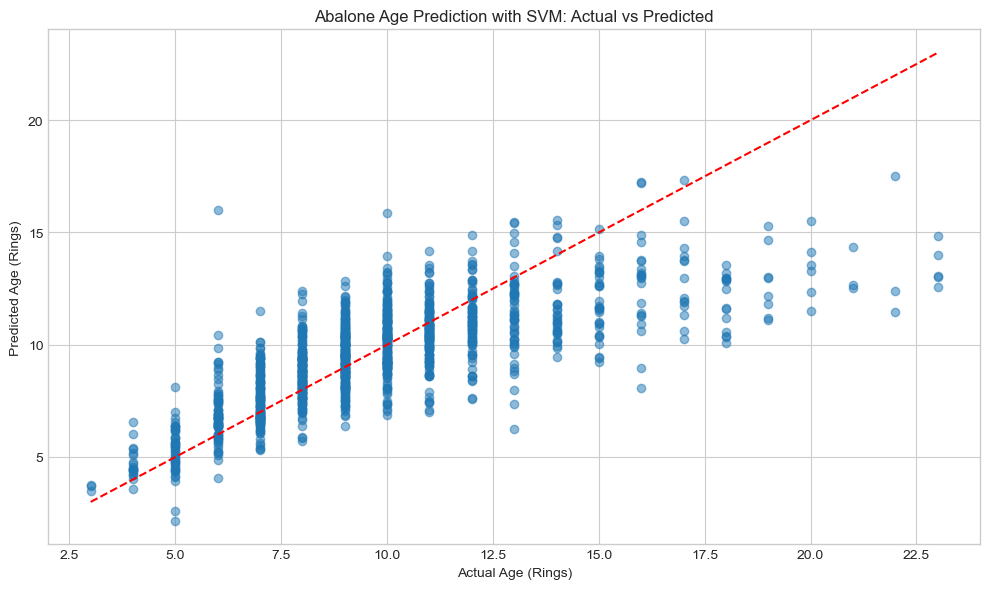

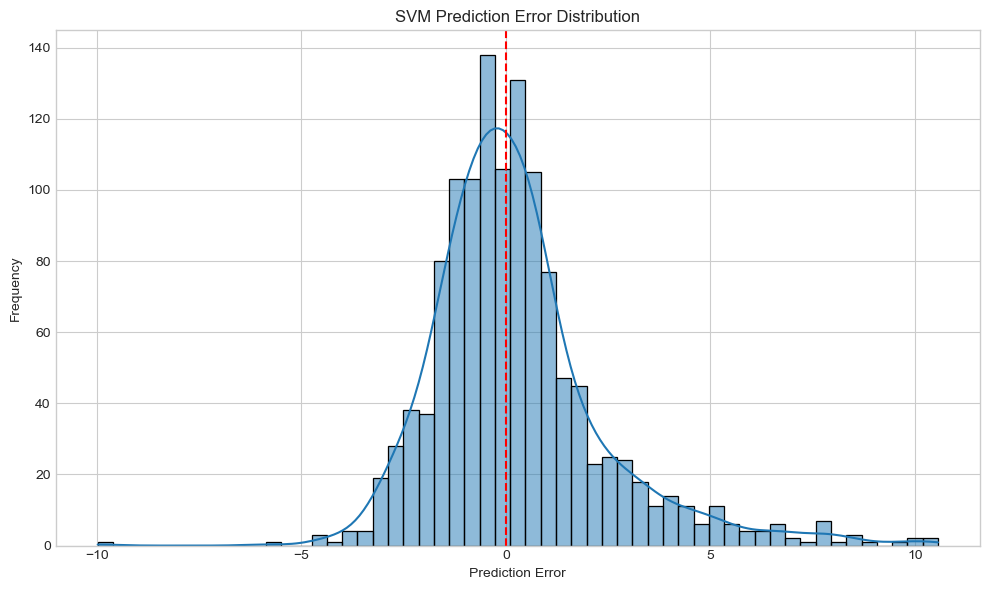


比较不同核函数的性能...
核函数 linear: RMSE = 2.2165, R² = 0.5162
核函数 poly: RMSE = 2.1864, R² = 0.5293
核函数 rbf: RMSE = 2.1450, R² = 0.5469
核函数 sigmoid: RMSE = 539.8490, R² = -28699.1095


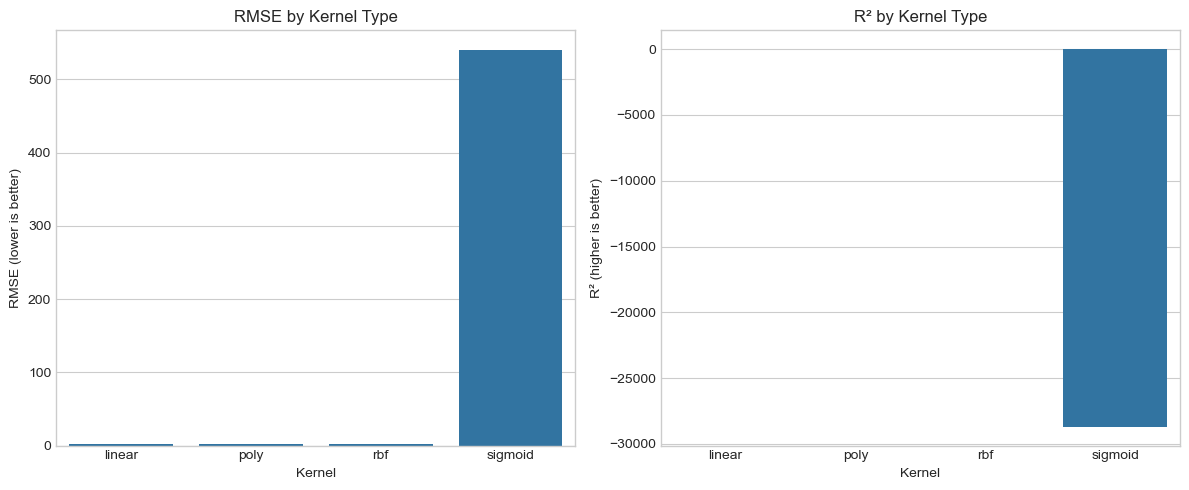


模型已保存为 'abalone_svm_model.pkl'

模型加载和使用示例:
样本预测结果:
[11.56278323  9.67905537 13.74009187 11.19954418 11.54611263]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import joblib

# 假设X和y已经定义
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. 创建基础SVM模型
print("\n开始训练基础SVM模型...")
svm_model = SVR(kernel='rbf', gamma='scale')
svm_model.fit(X_train, y_train)

# 2. 在测试集上进行预测
y_pred = svm_model.predict(X_test)

# 3. 评估基础模型
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n基础SVM模型评估:")
print(f"均方误差 (MSE): {mse:.4f}")
print(f"均方根误差 (RMSE): {rmse:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"决定系数 (R²): {r2:.4f}")

# 4. 使用交叉验证评估模型
print("\n开始交叉验证...")
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"\n交叉验证 RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

# 5. 超参数调优
print("\n开始超参数调优...")

small_param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.1],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=small_param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n最佳参数:")
print(grid_search.best_params_)

# 打印所有结果以便更好地理解
print("\n所有参数组合的结果:")
results = pd.DataFrame(grid_search.cv_results_)
results_subset = results[['params', 'mean_test_score', 'rank_test_score']]
results_subset['mean_test_rmse'] = np.sqrt(-results_subset['mean_test_score'])
print(results_subset.sort_values('rank_test_score'))

# 6. 使用最佳参数创建优化模型
best_svm_model = grid_search.best_estimator_
print("\n最佳模型的所有参数:")
print(best_svm_model.get_params())

# 7. 评估优化后的模型
y_pred_best = best_svm_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\n优化后的SVM模型评估:")
print(f"均方误差 (MSE): {mse_best:.4f}")
print(f"均方根误差 (RMSE): {rmse_best:.4f}")
print(f"平均绝对误差 (MAE): {mae_best:.4f}")
print(f"决定系数 (R²): {r2_best:.4f}")

# 8. 可视化预测结果 - 使用英文标题和标签
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Age (Rings)')
plt.ylabel('Predicted Age (Rings)')
plt.title('Abalone Age Prediction with SVM: Actual vs Predicted')
plt.tight_layout()
plt.savefig('svm_prediction_results.png')
plt.show()

# 9. 预测误差分布 - 使用英文标题和标签
errors = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('SVM Prediction Error Distribution')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.savefig('svm_error_distribution.png')
plt.show()

# 10. 比较不同核函数的性能
print("\n比较不同核函数的性能...")
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_scores = []

for kernel in kernels:
    model = SVR(kernel=kernel, gamma='scale', C=best_svm_model.C)
    model.fit(X_train, y_train)
    y_pred_kernel = model.predict(X_test)
    rmse_kernel = np.sqrt(mean_squared_error(y_test, y_pred_kernel))
    r2_kernel = r2_score(y_test, y_pred_kernel)
    kernel_scores.append((kernel, rmse_kernel, r2_kernel))
    print(f"核函数 {kernel}: RMSE = {rmse_kernel:.4f}, R² = {r2_kernel:.4f}")

# 可视化不同核函数的性能比较 - 使用英文标题和标签
kernel_df = pd.DataFrame(kernel_scores, columns=['Kernel', 'RMSE', 'R2'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Kernel', y='RMSE', data=kernel_df)
plt.title('RMSE by Kernel Type')
plt.ylabel('RMSE (lower is better)')

plt.subplot(1, 2, 2)
sns.barplot(x='Kernel', y='R2', data=kernel_df)
plt.title('R² by Kernel Type')
plt.ylabel('R² (higher is better)')

plt.tight_layout()
plt.savefig('svm_kernel_comparison.png')
plt.show()

# 11. 保存最佳模型
joblib.dump(best_svm_model, 'abalone_svm_model.pkl')
print("\n模型已保存为 'abalone_svm_model.pkl'")

# 12. 示例：如何加载和使用保存的模型
print("\n模型加载和使用示例:")
loaded_model = joblib.load('abalone_svm_model.pkl')
# 假设有新数据
sample = X_test.iloc[0:5]  # 取测试集的前5个样本作为示例
predictions = loaded_model.predict(sample)
print("样本预测结果:")
print(predictions)


In [ ]:
# 结合方法2和方法4的示例
from sklearn.model_selection import cross_val_score


def evaluate_models(models_dict, X, y, cv=5, test_size=0.3, random_state=42):
    """评估多个模型并返回结果"""
    # 分割数据
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    results = {}
    
    for name, model in models_dict.items():
        print(f"\n评估模型: {name}")
        
        # 交叉验证
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
        mae_cv = -cv_scores.mean()
        
        # 在测试集上评估
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_test = mean_absolute_error(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'mae_cv': mae_cv,
            'mae_test': mae_test
        }
        
        print(f"交叉验证MAE: {mae_cv:.4f}")
        print(f"测试集MAE: {mae_test:.4f}")
    
    # 创建比较表格
    comparison = pd.DataFrame({
        'Model': list(results.keys()),
        'CV MAE': [results[name]['mae_cv'] for name in results],
        'Test MAE': [results[name]['mae_test'] for name in results]
    })
    
    return comparison.sort_values('CV MAE')

# 定义要评估的模型
models = {
    'Linear Regression': LinearRegression(),
    'DecisionTree' : DecisionTreeRegressor(max_depth=5, random_state=42,min_samples_leaf=8,min_samples_split=2),
    'RandomForest' : RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators= 200, random_state=42),
    'Support Vector Machine': SVR(kernel='rbf', gamma='scale', C=10)
}

# 评估所有模型
results_table = evaluate_models(models, X, y, cv=5)
print("\n模型比较:")
print(results_table)



评估模型: Linear Regression
交叉验证MAE: 1.5957
测试集MAE: 1.5832

评估模型: DecisionTree
交叉验证MAE: 1.6666
测试集MAE: 1.6300

评估模型: RandomForest
交叉验证MAE: 1.5377
测试集MAE: 1.5394

评估模型: Support Vector Machine
交叉验证MAE: 1.4766
测试集MAE: 1.4867

模型比较:
                    Model    CV MAE  Test MAE
3  Support Vector Machine  1.476624  1.486653
2            RandomForest  1.537718  1.539372
0       Linear Regression  1.595711  1.583238
1            DecisionTree  1.666609  1.629956
